In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re

from scipy.sparse import csr_matrix
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.neighbors import NearestNeighbors

In [402]:
from scipy.spatial.distance import euclidean

from scipy.spatial.distance import cosine

In [2]:
#load the dataset into pandas dataframe
dfProducts = pd.read_csv('/Users/rpghosh/python-examples/reward360/data/products.csv', header=None)
dfTxn = pd.read_csv('/Users/rpghosh/python-examples/reward360/data/txn.csv')

In [5]:
dfTxn.shape

(1754515, 12)

In [6]:
dfProducts.shape

(80, 2)

In [9]:
# Add the column names to the Product dataframe
dfProducts.columns = ['Product', 'Price']

# Convert the column names into lower case 
# also remove any leading or lagging spaces, also whitespaces in between
# ----- Txn dataframe -----
# remove spaces in the product names
dfTxn['Product'] = dfTxn['Product'].apply ( lambda x: re.sub( '\s+', '', x) )

# conver to lower case
dfTxn['Product'] = dfTxn['Product'].apply ( lambda x: x.lower() )


# ----- Product dataframe -----
# remove spaces in the product names
dfProducts['Product'] = dfProducts['Product'].apply ( lambda x: re.sub( '\s+', '', x) )

# conver to lower case
dfProducts['Product'] = dfProducts['Product'].apply ( lambda x: x.lower() )

# Data cleaning

In [10]:
# search isna().sum() - basically np.nan values
dfProducts.isna().sum()


Product    0
Price      0
dtype: int64

In [11]:
dfTxn.isna().sum()

CustomerId                    0
CustomerEmailAddress          0
CustomerGender                0
CustomerAge                   0
CustomerDeviceType            0
OrderId                       0
OrderAmount                   0
Product                       0
OrderStatus                   0
DeliveryPinCode               0
OrderPaymentMode              0
OrderDate               1754515
dtype: int64

In [12]:
dfTxn.shape

(1754515, 12)

In [ ]:
# all records have nan value for dfTxn.OrderDate
# so we can remove that column
# also the EmailAddress column seems to be of no use, since we 
# already have CustomerId

In [13]:
dfTxn.drop(columns=['CustomerEmailAddress', 'OrderDate'], inplace=True)

In [14]:
dfTxn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1754515 entries, 0 to 1754514
Data columns (total 10 columns):
 #   Column              Dtype 
---  ------              ----- 
 0   CustomerId          object
 1   CustomerGender      object
 2   CustomerAge         int64 
 3   CustomerDeviceType  object
 4   OrderId             int64 
 5   OrderAmount         int64 
 6   Product             object
 7   OrderStatus         object
 8   DeliveryPinCode     int64 
 9   OrderPaymentMode    object
dtypes: int64(4), object(6)
memory usage: 133.9+ MB


# Data exploration 

In [23]:
dfProducts.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Price,80.0,12746.25,20683.020271,200.0,1000.0,5000.0,10000.0,100000.0


In [ ]:
# looking at the price column it seems that some items are siginificantly higher priced than others 

<AxesSubplot:title={'center':"Countplot of each Product's Price"}, xlabel='Price', ylabel='count'>

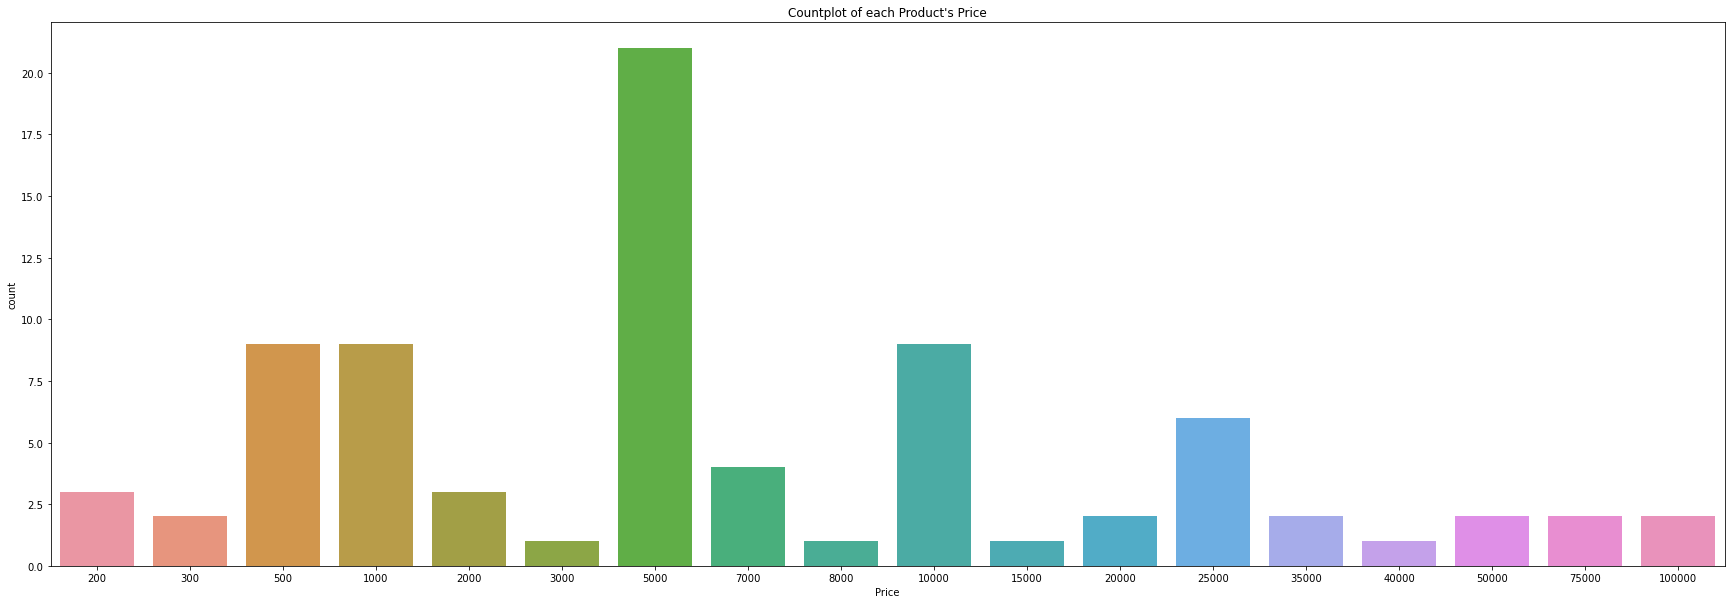

In [24]:
plt.figure(figsize=(30, 10))
plt.title ('Countplot of each Product\'s Price')
sns.countplot(x=dfProducts.Price)

In [43]:
# so we need to divide the price column into categories, maybe 5 bins using pd.qcut()

In [44]:
numBins = 5
dfProducts['PriceCategory'] = pd.qcut(x=dfProducts['Price'], q = numBins, labels=[i+1 for i in range(numBins)] )

In [80]:
# these are the bins

pd.qcut(x=dfProducts['Price'], q = numBins ).values.unique().to_list()


[Interval(199.999, 1000.0, closed='right'),
 Interval(1000.0, 5000.0, closed='right'),
 Interval(5800.0, 20000.0, closed='right'),
 Interval(20000.0, 100000.0, closed='right')]

In [45]:
dfProducts.head(5)

,Product,Price,PriceCategory
0,tshirt,1000,1
1,jeans,2000,2
2,shirt,1000,1
3,trouser,2000,2
4,skirt,5000,2


In [47]:
# we need to apply this Price Category to the dfTxn dataframe as well

In [70]:
dfTxn.ProductPriceCategory.unique()

array([4, 2, 1, 5])

<AxesSubplot:title={'center':'Countplot of Product-Price Category'}, xlabel='ProductPriceCategory', ylabel='count'>

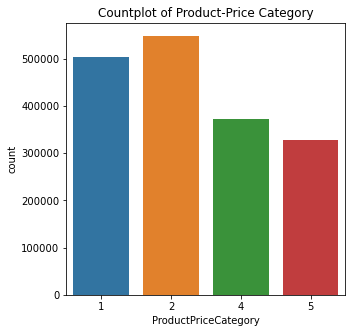

In [71]:
#countplot shows there is no item transaction in price bin 3 
# also maximum item in bin 2

plt.figure(figsize=(5, 5))
plt.title ('Countplot of Product-Price Category')
sns.countplot(x=dfTxn.ProductPriceCategory)

In [62]:
# we see pincodes based from 3 major cities - delhi, mumbai and banglore
# we will assign zone names of each of these of pincodes 
# use the delhi , mumbai data as training
# use 50% of bangalore data for validation of hyper parameter
# and another 50% as test data

In [63]:
# zones dictionary 
zones = {'Delhi': 110000, 'Mumbai':400000, 'Bangalore': 560000}


In [64]:
# function to get zone
def getZone(pincode):
    if pincode < 100000 or pincode > 570000:
        return None
    for k, v in zones.items():
        if abs(v - pincode) < 100000:
            return k
    return None
        

In [65]:
dfTxn['Zone'] = dfTxn['DeliveryPinCode'].apply(getZone)

<AxesSubplot:title={'center':'Countplot of Zome-wise transactions'}, xlabel='Zone', ylabel='count'>

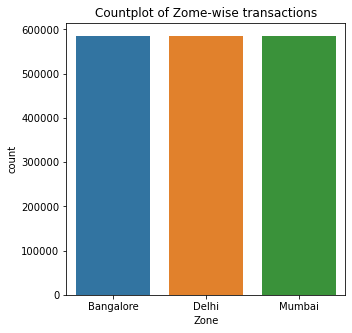

In [69]:
plt.figure(figsize=(5, 5))
plt.title ('Countplot of Zome-wise transactions')
sns.countplot(x=dfTxn.Zone)

In [81]:
# list of all products

In [82]:
allProducts = dfProducts.Product.to_list()

In [84]:
','.join(allProducts)

'tshirt,jeans,shirt,trouser,skirt,blouse,headphone,laptop,cellphone,usbcable,deodrant,shavingcream,perfume,vest,brief,handbag,laptopbag,travellersbag,watch,passportbag,menssuit,saree,formalshoes,casualshoes,sleepers,handkerchief,books,ballpen,inkpen,notepad,tablet,speakers,googlehome,alexa,television,hometheatre,powerbank,smartwatch,usbstick,monitors,printer,router,lights,smartlights,homeautomation,usbstick,cleartripvoucher,yatravoucher,irctcvoucher,hoteltajgiftcard,hotelmarriotgiftcard,ubercashcard,olacashcard,swiggycashcard,zomatocashcard,vedantugiftcard,byjugiftcard,bookmyshowgiftcard,netflixvoucher,hotstarvoucher,zee5voucher,vootvoucher,sonylivvoucher,sunglasses,cultfitvoucher,makemytripvoucher,agodavoucher,kindle,bharatpetroleumvoucher,dreams11giftcard,rummycirclegiftcard,tataskygiftcard,exotictea,luxurywatch,goldjewelley,diamondjewellery,woodfurniture,metalfurniture,fancylights,headoutvoucher'

In [ ]:
# countplot of payment modes

<AxesSubplot:title={'center':'Countplot of Payment mode'}, xlabel='OrderPaymentMode', ylabel='count'>

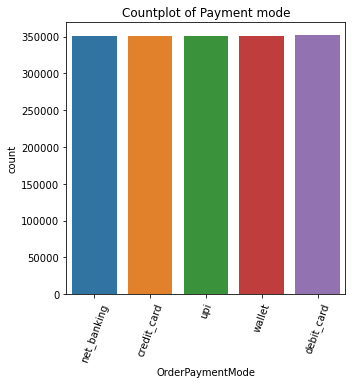

In [86]:
plt.figure(figsize=(5, 5))
plt.title ('Countplot of Payment mode')
plt.xticks(rotation=70)
sns.countplot(x=dfTxn.OrderPaymentMode)

In [88]:
# order status 

In [91]:
dfTxn.OrderStatus.unique()

array(['Item Returned', 'Delivered', 'Payment Incomplete',
       'Order Cancelled'], dtype=object)

<AxesSubplot:title={'center':'Countplot of each OrderStatus'}, xlabel='OrderStatus', ylabel='count'>

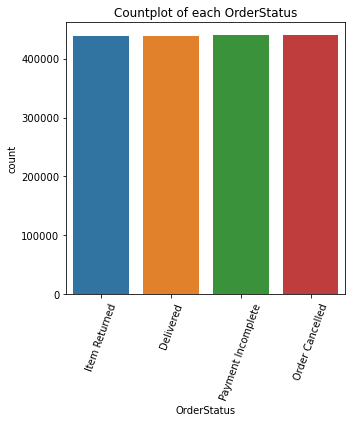

In [92]:
plt.figure(figsize=(5, 5))
plt.title ('Countplot of each OrderStatus')
plt.xticks(rotation=70)
sns.countplot(x=dfTxn.OrderStatus)

In [93]:
# in order to make any decision we have to 
# give some weightage to an OrderStatus that 
# so eventually we can come up with a score for the customer-item relationship
# and use that score in our model building

# so what I decided is to give the following weightages 

# delivered = 50 
# payment incomplete = 10
# order cancelled = 1
# item returned = 0

# lets have a function for it

In [94]:
def getUserScore(x):
    if x == 'Delivered':
        return 50
    elif x == 'Payment Incomplete':
        return 10 
    elif x == 'Order Cancelled':
        return 1
    else:
        return 0 

In [95]:
dfTxn['OrderStatusScore'] = dfTxn['OrderStatus'].apply(getUserScore)

In [96]:
# similarly for the payment mode - lets make it into codes 

paymentCodes = {'net_banking':1, 'credit_card':2, 'upi':3, 'wallet':4, 'debit_card':5}
dfTxn['PaymentMode'] = dfTxn['OrderPaymentMode'].apply( lambda x: paymentCodes[x])

In [97]:
# similary CustomerDeviceType

dfTxn.CustomerDeviceType.unique()
deviceTypes = {'iOS':1, 'Windows':1, 'Linux':2, 'Android':3}
dfTxn['DeviceType'] = dfTxn['CustomerDeviceType'].apply(lambda x: deviceTypes[x])

In [98]:
# similary gender

genderTypes = {'Male': 1, 'Female':2}
dfTxn['Gender'] = dfTxn['CustomerGender'].apply(lambda x: genderTypes[x])

In [99]:
# similarly age

dfTxn['Age'] = 0
dfTxn['Age'] = pd.qcut(x=dfTxn['CustomerAge'],q=5,labels=[1,2,3,4,5])

In [103]:
dfTxn.tail(2)

,CustomerId,CustomerGender,CustomerAge,CustomerDeviceType,OrderId,OrderAmount,Product,OrderStatus,DeliveryPinCode,OrderPaymentMode,ProductPriceCategory,Zone,OrderStatusScore,PaymentMode,DeviceType,Gender,Age
1754513,Y6BIVCODU7,Male,26,Android,8881802,7000,router,Delivered,400038,net_banking,4,Mumbai,50,1,3,1,2
1754514,Y6BIVCODU7,Male,26,Android,502102,200,shavingcream,Delivered,400038,debit_card,1,Mumbai,50,5,3,1,2


In [102]:
dfTxn.head(2) 

,CustomerId,CustomerGender,CustomerAge,CustomerDeviceType,OrderId,OrderAmount,Product,OrderStatus,DeliveryPinCode,OrderPaymentMode,ProductPriceCategory,Zone,OrderStatusScore,PaymentMode,DeviceType,Gender,Age
0,Q8RV5E9KFX,Male,48,iOS,398629,10000,googlehome,Item Returned,560034,net_banking,4,Bangalore,0,1,1,1,5
1,Q8RV5E9KFX,Male,48,iOS,2593111,5000,dreams11giftcard,Item Returned,110001,credit_card,2,Delhi,0,2,1,1,5


In [ ]:
# get the training data

In [130]:
dfTrain = dfTxn[(dfTxn.Zone.isin(['Delhi','Mumbai']))]
#['CustomerId','Gender', 'Age', 'PaymentMode', 'DeviceType','OrderStatusScore', 'ProductPriceCategory' , 'Product']

In [132]:
dfTrain = dfTrain[['CustomerId','Gender', 'Age', 'PaymentMode', 'DeviceType','OrderStatusScore', 'ProductPriceCategory' , 'Product']]

In [133]:
dfTrain.head(2)

,CustomerId,Gender,Age,PaymentMode,DeviceType,OrderStatusScore,ProductPriceCategory,Product
1,Q8RV5E9KFX,1,5,2,1,0,2,dreams11giftcard
2,Q8RV5E9KFX,1,5,3,1,0,1,sleepers


In [139]:
dfTrain.shape

(1169993, 8)

In [140]:
dfTxn.shape

(1754515, 17)

In [141]:
# in a new dataframe we get the score of relationship between a customerId - product

In [142]:
group = dfTrain.groupby(['CustomerId','Product'])['OrderStatusScore'].sum().reset_index()

In [143]:
group.head(3)

,CustomerId,Product,OrderStatusScore
0,0127NRGL6D,googlehome,50
1,0127NRGL6D,hotstarvoucher,50
2,0127NRGL6D,luxurywatch,1


In [144]:
group.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1072896 entries, 0 to 1072895
Data columns (total 3 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   CustomerId        1072896 non-null  object
 1   Product           1072896 non-null  object
 2   OrderStatusScore  1072896 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 24.6+ MB


<AxesSubplot:title={'center':'Countplot of each OrderStatusScore'}, xlabel='OrderStatusScore', ylabel='count'>

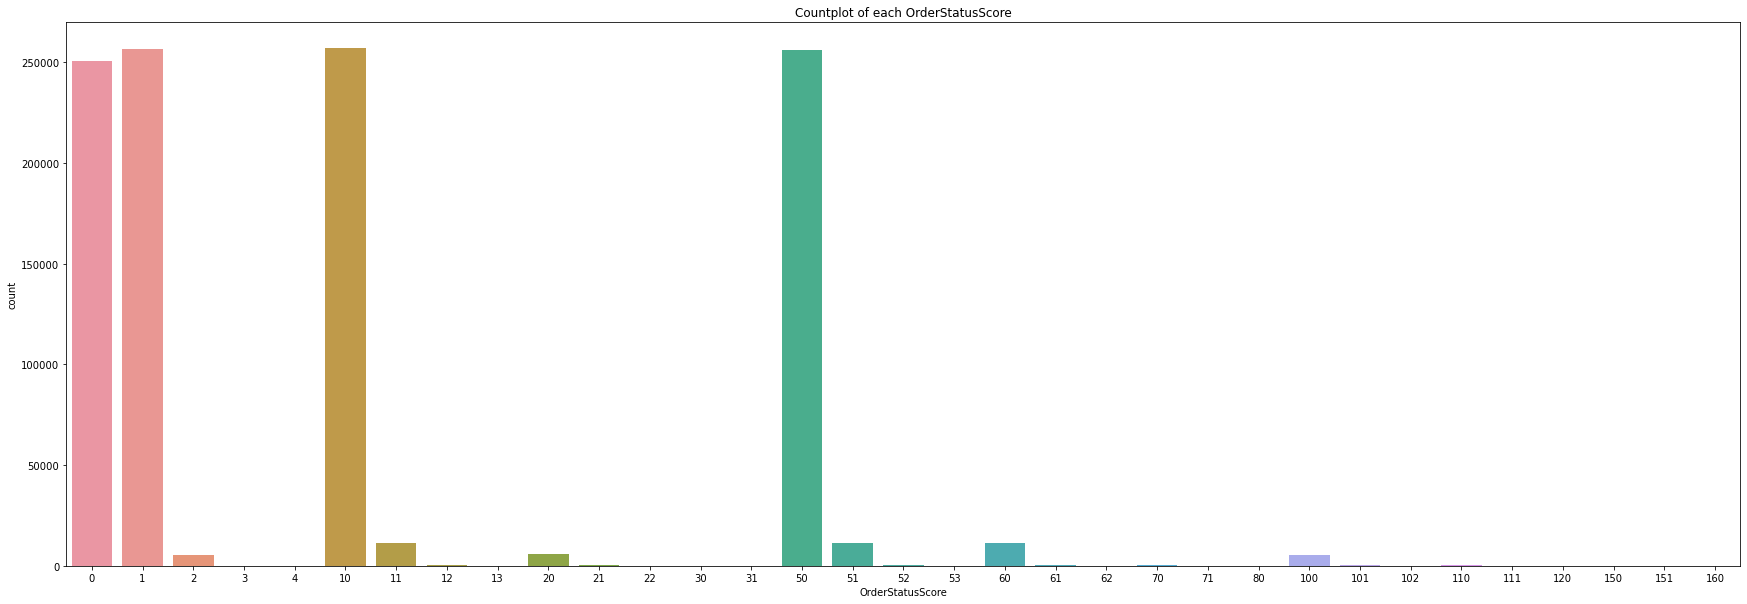

In [145]:
plt.figure(figsize=(30,10))
plt.title('Countplot of each OrderStatusScore')
sns.countplot(x=group.OrderStatusScore)

In [146]:

# we need to create a dataframe where each customer can be represented as a vector
# and the field of the vector will be each product
# and values will be the OrderStatusScore for each customer-product relationship

In [147]:
dfFinal = group.pivot_table(index='CustomerId', columns='Product', values='OrderStatusScore').fillna(0)

In [148]:
# list of all customers
dfFinal.index

Index(['0127NRGL6D', '012BLUSFE9', '012ILK3ZTP', '012JSI4XBW', '012LB9SYXT',
       '012RTOSXZH', '012V8B4AFR', '012YGK4AIC', '0138RN4QFP', '013N62ZYO9',
       ...
       'ZYU48SOQL6', 'ZYU5HM4AVG', 'ZYUXNAQS69', 'ZYV28HA3OS', 'ZYVRG5SHD7',
       'ZYVSA0Q46K', 'ZYW5JUC9TM', 'ZYWC76SJV3', 'ZYXABSMO0U', 'ZYXOTLGBRA'],
      dtype='object', name='CustomerId', length=99932)

In [149]:
# list of all features of each customer
dfFinal.columns

Index(['agodavoucher', 'alexa', 'ballpen', 'bharatpetroleumvoucher', 'blouse',
       'bookmyshowgiftcard', 'books', 'brief', 'byjugiftcard', 'casualshoes',
       'cellphone', 'cleartripvoucher', 'cultfitvoucher', 'deodrant',
       'diamondjewellery', 'dreams11giftcard', 'exotictea', 'fancylights',
       'formalshoes', 'goldjewelley', 'googlehome', 'handbag', 'handkerchief',
       'headoutvoucher', 'headphone', 'homeautomation', 'hometheatre',
       'hotelmarriotgiftcard', 'hoteltajgiftcard', 'hotstarvoucher', 'inkpen',
       'irctcvoucher', 'jeans', 'kindle', 'laptop', 'laptopbag', 'lights',
       'luxurywatch', 'makemytripvoucher', 'menssuit', 'metalfurniture',
       'monitors', 'netflixvoucher', 'notepad', 'olacashcard', 'passportbag',
       'perfume', 'powerbank', 'printer', 'router', 'rummycirclegiftcard',
       'saree', 'shavingcream', 'shirt', 'skirt', 'sleepers', 'smartlights',
       'smartwatch', 'sonylivvoucher', 'speakers', 'sunglasses',
       'swiggycashcard', '

In [150]:
dfFinal.shape

(99932, 79)

In [151]:
dfFinal.head(2)

Product,agodavoucher,alexa,ballpen,bharatpetroleumvoucher,blouse,bookmyshowgiftcard,books,brief,byjugiftcard,casualshoes,...,usbcable,usbstick,vedantugiftcard,vest,vootvoucher,watch,woodfurniture,yatravoucher,zee5voucher,zomatocashcard
CustomerId,,,,,,,,,,,,,,,,,,,,,
0127NRGL6D,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,50.0,0.0,10.0
012BLUSFE9,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [152]:
# since this is a sparse matrix we will convert it to csr_matrix()

In [153]:
mtrxTobeUsed = csr_matrix(dfFinal.values)

In [916]:
mtrxTobeUsed.shape

(99932, 79)

In [917]:
mtrxTobeUsed

<99932x79 sparse matrix of type '<class 'numpy.float64'>'
	with 822464 stored elements in Compressed Sparse Row format>

# Case 1 -> metric = "cosine similarity" , n_neighbors= 5

In [910]:
# we will use cosine similarity to find the nearest neighbours 
# brute force algorithm

model = NearestNeighbors(metric='cosine', algorithm='brute')


In [911]:
model.get_params()

{'algorithm': 'brute',
 'leaf_size': 30,
 'metric': 'cosine',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'radius': 1.0}

In [912]:
model.fit(mtrxTobeUsed)

NearestNeighbors(algorithm='brute', metric='cosine')

In [926]:
def kmeansRecos(CUSTOMERID='012ILK3ZTP', N_NEIGHBOURS=5):
    
    distances, indices = model.kneighbors( dfFinal[dfFinal.index == CUSTOMERID].values.reshape(1,-1),\
                                          n_neighbors=N_NEIGHBOURS)
    nearestCustomers = []
    for i in range(0, len(distances.flatten())):
        if i == 0:
            print(f"Nearest Neighbours of Customer : {dfFinal.index[indices.flatten()[i]]} ")
        else:
            customer = dfFinal.index[indices.flatten()[i]]
            customerDistance = distances.flatten()[i]
            print('{0}: Customer={1}, with distance of {2}'.format(i, customer, customerDistance))

            nearestCustomers.append(customer)

    # we will try to find the predicted Vector as a mean of all the nearest neighbours 
    predictedVector = np.zeros((1,79))

    numNearestCustomers = len(nearestCustomers)
    for customer in nearestCustomers:
        predictedVector = predictedVector + dfFinal[(dfFinal.index == customer)].values

    predictedVector = predictedVector / numNearestCustomers

    # find the actual vector 
    actual = dfFinal[dfFinal.index == CUSTOMERID].values.reshape(1,-1)

    # similarity of actual and predicted 
    distance = cosine(actual, predicted)
    similarity = 1 - distance

    print(f"Recommendations from model has a similarity of {similarity} with actual behavior for Customer: {CUSTOMERID} ")
    #print(f"Recommendations for {CUSTOMERID} has a distance of {distance} from actual")    

In [927]:
kmeansRecos(CUSTOMERID='012ILK3ZTP', N_NEIGHBOURS=5)

Nearest Neighbours of Customer : 012ILK3ZTP 
1: Customer=KRI5E38NCX, with distance of 0.16895293337990658
2: Customer=97Y16X03UW, with distance of 0.1758747340250364
3: Customer=1NT0E8JZKX, with distance of 0.23743680988734694
4: Customer=SCPBT1XQ40, with distance of 0.2502589435386875
Recommendations from model has a similarity of 0.8760816777112866 with actual behavior for Customer: 012ILK3ZTP 


In [928]:

# lets select some random products

numRecords = len(dfTxn)

for _ in range(100):
    
    randomIdx = np.random.choice(numRecords)
    
    customer = dfTxn.CustomerId[randomIdx]
    
    print(f"\nRecommendation to customer {customer=} ... \n")
    kmeansRecos(CUSTOMERID=customer)
    #kmeansRecos()
    

#kmeansRecos(CUSTOMERID='012ILK3ZTP', N_NEIGHBOURS=5)


Recommendation to customer customer='13BQ8DLFMH' ... 

Nearest Neighbours of Customer : 13BQ8DLFMH 
1: Customer=EXFNWLGYSZ, with distance of 0.2675443068093474
2: Customer=NR6GKMTCVW, with distance of 0.3022021298280486
3: Customer=B2OFXV5MLA, with distance of 0.31056246493607476
4: Customer=046ALH1B3C, with distance of 0.327439913617098
Recommendations from model has a similarity of 0.022789255410057607 with actual behavior for Customer: 13BQ8DLFMH 

Recommendation to customer customer='54SF921LT7' ... 

Nearest Neighbours of Customer : 54SF921LT7 
1: Customer=FLE2I0DJ7N, with distance of 0.028150322498222913
2: Customer=GNF9KM82DV, with distance of 0.030377006958170694
3: Customer=52FD408KTZ, with distance of 0.03762733964278109
4: Customer=CXQGMS8TY9, with distance of 0.03781594771129626
Recommendations from model has a similarity of 0.005653812402041769 with actual behavior for Customer: 54SF921LT7 

Recommendation to customer customer='4JRW5HBXCS' ... 

Nearest Neighbours of Cust

Recommendations from model has a similarity of 0.1053669737337386 with actual behavior for Customer: A8YM7OX9WZ 

Recommendation to customer customer='TNWS71CYGB' ... 

Nearest Neighbours of Customer : TNWS71CYGB 
1: Customer=H5D0OINCK2, with distance of 0.2283426467520474
2: Customer=VLYAEMGK1Z, with distance of 0.2998480447497691
3: Customer=TS8MWC1FEV, with distance of 0.3003424066613549
4: Customer=KL5MFDVJCH, with distance of 0.3083730735717165
Recommendations from model has a similarity of 0.0012103474884040955 with actual behavior for Customer: TNWS71CYGB 

Recommendation to customer customer='RXZM0PW8HD' ... 

Nearest Neighbours of Customer : RXZM0PW8HD 
1: Customer=KLEN7QI24C, with distance of 0.14980196827446757
2: Customer=W6OGI3QEV1, with distance of 0.18899959790590115
3: Customer=D3SLQ5OWFI, with distance of 0.18899959790590115
4: Customer=NEBOPU6ASL, with distance of 0.18899959790590115
Recommendations from model has a similarity of 0.005188827253965633 with actual behav

Recommendations from model has a similarity of 0.03407472820146307 with actual behavior for Customer: RZ3M4WN80P 

Recommendation to customer customer='6TZK31C49H' ... 

Nearest Neighbours of Customer : 6TZK31C49H 
1: Customer=JU1O23FZVW, with distance of 0.23258939684968238
2: Customer=317IM589HT, with distance of 0.24170003853298194
3: Customer=27TDS5C0P8, with distance of 0.24748818496459002
4: Customer=6GF1HPKDZW, with distance of 0.2573934198120368
Recommendations from model has a similarity of 0.006637474876535987 with actual behavior for Customer: 6TZK31C49H 

Recommendation to customer customer='ZY8W7JAF12' ... 

Nearest Neighbours of Customer : ZY8W7JAF12 
1: Customer=B4IFYD1UZV, with distance of 0.22385970317140935
2: Customer=TMG9C7HDWJ, with distance of 0.24576124807026212
3: Customer=WODCL4E0X6, with distance of 0.24590622428533104
4: Customer=E3AMUO5NFG, with distance of 0.2546347098785495
Recommendations from model has a similarity of 0.05935872200758596 with actual beha

Recommendations from model has a similarity of 0.016423356339039796 with actual behavior for Customer: F9Z8W7TN0B 

Recommendation to customer customer='9PR5CSU31T' ... 

Nearest Neighbours of Customer : 9PR5CSU31T 
1: Customer=F3XBLCO8YU, with distance of 0.1294773598458583
2: Customer=Z65F7CBD0G, with distance of 0.16056992862554564
3: Customer=XCIAHBR32S, with distance of 0.18507395162406315
4: Customer=D46RH9PBZV, with distance of 0.19286568772873824
Recommendations from model has a similarity of 0.18280884932161057 with actual behavior for Customer: 9PR5CSU31T 

Recommendation to customer customer='0YOZLG3RKN' ... 

Nearest Neighbours of Customer : 0YOZLG3RKN 
1: Customer=VIWXPZ85FT, with distance of 0.010143548472502317
2: Customer=423H1VY8LG, with distance of 0.0126089481949484
3: Customer=J9HCFWAR43, with distance of 0.015056017760848195
4: Customer=2GQU3P9EJF, with distance of 0.019848023487477717
Recommendations from model has a similarity of 0.21152749567806028 with actual b

Recommendations from model has a similarity of 0.24561173784059231 with actual behavior for Customer: R4UXTOM15B 

Recommendation to customer customer='27RUJP3KWE' ... 

Nearest Neighbours of Customer : 27RUJP3KWE 
1: Customer=4ZTJ0EMG8H, with distance of 0.23570952911988596
2: Customer=SXVRB8D1HC, with distance of 0.2433611662097167
3: Customer=Q25JL4PNEB, with distance of 0.24376106212319482
4: Customer=QMND8RETY6, with distance of 0.25755771143470274
Recommendations from model has a similarity of 0.01668253563423383 with actual behavior for Customer: 27RUJP3KWE 

Recommendation to customer customer='H5BR8XJ0CT' ... 

Nearest Neighbours of Customer : H5BR8XJ0CT 
1: Customer=3H6OXP2IKZ, with distance of 0.2653124805484455
2: Customer=CHW9LBMO85, with distance of 0.2877707224440401
3: Customer=EUXPMGAS9T, with distance of 0.29436689714597597
4: Customer=M7Q1VKW0JA, with distance of 0.29645840876875296
Recommendations from model has a similarity of 0.09726239628082745 with actual behavi

Recommendations from model has a similarity of 0.002111466661305128 with actual behavior for Customer: V2I1KED8X7 

Recommendation to customer customer='3EB7R4GH1M' ... 

Nearest Neighbours of Customer : 3EB7R4GH1M 
1: Customer=KUJ65GNQHY, with distance of 0.10316599437746121
2: Customer=4OCUTBQ9V3, with distance of 0.11875511168633768
3: Customer=OGUSHX2NPF, with distance of 0.1640000112647172
4: Customer=891X5VJNAW, with distance of 0.16839349699395711
Recommendations from model has a similarity of 0.00511295257531974 with actual behavior for Customer: 3EB7R4GH1M 

Recommendation to customer customer='KR0WLH94FM' ... 

Nearest Neighbours of Customer : KR0WLH94FM 
1: Customer=IASOWDJG45, with distance of 0.02871061471923475
2: Customer=4WSZQ6OIET, with distance of 0.028897347276046648
3: Customer=N7QEAML8C6, with distance of 0.03371674502809052
4: Customer=XHCJDIFGUS, with distance of 0.03846509442724688
Recommendations from model has a similarity of 0.0020710568896724624 with actual 

# Case 2 -> metric = "cosine similarity" , n_neighbors= 3

In [412]:
model = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=3)
model.get_params()

{'algorithm': 'brute',
 'leaf_size': 30,
 'metric': 'cosine',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 3,
 'p': 2,
 'radius': 1.0}

In [413]:
model.fit(mtrxTobeUsed)

NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=3)

In [415]:
mtrxTobeUsed.shape

(99932, 79)

In [416]:
mtrxTobeUsed

<99932x79 sparse matrix of type '<class 'numpy.float64'>'
	with 822464 stored elements in Compressed Sparse Row format>

In [417]:
kmeansRecos(CUSTOMERID='012ILK3ZTP', N_NEIGHBOURS=3)

Nearest Neighbours of Customer 0, 012ILK3ZTP 
1: Customer=KRI5E38NCX, with distance of 0.16895293337990658
2: Customer=97Y16X03UW, with distance of 0.1758747340250364
Recommendations for 012ILK3ZTP has a similarity of 0.8760816777112866 with actual behavior
Recommendations for 012ILK3ZTP has a distance of 0.12391832228871336 from actual


In [418]:
# ======

In [422]:
model = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20)
model.fit(mtrxTobeUsed)
kmeansRecos(CUSTOMERID='012ILK3ZTP', N_NEIGHBOURS=10)

Nearest Neighbours of Customer 0, 012ILK3ZTP 
1: Customer=KRI5E38NCX, with distance of 0.16895293337990658
2: Customer=97Y16X03UW, with distance of 0.1758747340250364
3: Customer=1NT0E8JZKX, with distance of 0.23743680988734694
4: Customer=SCPBT1XQ40, with distance of 0.2502589435386875
5: Customer=GSVO4F716P, with distance of 0.2646380257527925
6: Customer=OHJ2PXNBW9, with distance of 0.26536739251321384
7: Customer=76ASXM30HK, with distance of 0.2847049434988981
8: Customer=R4T02NUXKS, with distance of 0.292963918886737
9: Customer=QXDCRKGWTH, with distance of 0.292963918886737
Recommendations for 012ILK3ZTP has a similarity of 0.8760816777112866 with actual behavior
Recommendations for 012ILK3ZTP has a distance of 0.12391832228871336 from actual


# content based filtering based on OrderStatusScore and AgeBasedScore

In [573]:
# prepare the test and validation set

In [670]:
dfTxn.Gender.unique()

array([1, 2])

In [700]:
dfTxn.Age.unique()

[5, 1, 2, 3, 4]
Categories (5, int64): [1 < 2 < 3 < 4 < 5]

In [728]:
dfTest = dfTxn[ dfTxn.Zone.isin(['Bangalore','Delhi','Mumbai']) ]

In [732]:
dfTest.shape

(1754515, 17)

In [733]:
dfTest.columns

Index(['CustomerId', 'CustomerGender', 'CustomerAge', 'CustomerDeviceType',
       'OrderId', 'OrderAmount', 'Product', 'OrderStatus', 'DeliveryPinCode',
       'OrderPaymentMode', 'ProductPriceCategory', 'Zone', 'OrderStatusScore',
       'PaymentMode', 'DeviceType', 'Gender', 'Age'],
      dtype='object')

In [734]:
dfValidation = dfTest.iloc[ :50000 , :  ]
#dfValidation = dfTest.iloc[ : , :  ]

In [735]:
dfValidation.shape

(50000, 17)

In [736]:
dfValidation.index

Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                9,
            ...
            49990, 49991, 49992, 49993, 49994, 49995, 49996, 49997, 49998,
            49999],
           dtype='int64', length=50000)

In [737]:
dfValidation.columns

Index(['CustomerId', 'CustomerGender', 'CustomerAge', 'CustomerDeviceType',
       'OrderId', 'OrderAmount', 'Product', 'OrderStatus', 'DeliveryPinCode',
       'OrderPaymentMode', 'ProductPriceCategory', 'Zone', 'OrderStatusScore',
       'PaymentMode', 'DeviceType', 'Gender', 'Age'],
      dtype='object')

# based on OrderStatusScore

<AxesSubplot:title={'center':'Price based spread of products '}, xlabel='Price', ylabel='count'>

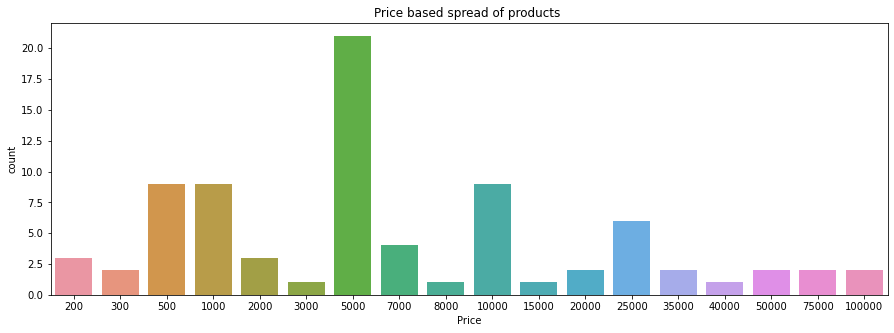

In [818]:
plt.figure(figsize=(15,5))
plt.title('Price based spread of products ')
sns.countplot (x=dfProducts['Price'])


In [754]:
# dataframe which gives an idea of degree of relationship (orderScore) in between a customer and product
dfContent = dfValidation.groupby(['Product','CustomerId'])['OrderStatusScore'].sum().reset_index()


In [755]:
dfContent.shape

(43905, 3)

In [758]:
dfTest.CustomerId.nunique()

100000

In [759]:
dfContent.columns

Index(['Product', 'CustomerId', 'OrderStatusScore'], dtype='object')

In [760]:
# i got around 3324 customers that will be my features

dfContent.CustomerId.unique().shape

(2843,)

In [761]:
# number of products is 79

dfContent.Product.unique().shape

(79,)

In [762]:
dfContent.head(2)

,Product,CustomerId,OrderStatusScore
0,agodavoucher,06RL1ZIQ2Y,50
1,agodavoucher,07HM2D5P3A,10


In [763]:
dfContentPivot = dfContent.pivot_table(index= 'Product', columns= 'CustomerId', values = 'OrderStatusScore').fillna(0)

In [764]:
dfContentPivot.index

Index(['agodavoucher', 'alexa', 'ballpen', 'bharatpetroleumvoucher', 'blouse',
       'bookmyshowgiftcard', 'books', 'brief', 'byjugiftcard', 'casualshoes',
       'cellphone', 'cleartripvoucher', 'cultfitvoucher', 'deodrant',
       'diamondjewellery', 'dreams11giftcard', 'exotictea', 'fancylights',
       'formalshoes', 'goldjewelley', 'googlehome', 'handbag', 'handkerchief',
       'headoutvoucher', 'headphone', 'homeautomation', 'hometheatre',
       'hotelmarriotgiftcard', 'hoteltajgiftcard', 'hotstarvoucher', 'inkpen',
       'irctcvoucher', 'jeans', 'kindle', 'laptop', 'laptopbag', 'lights',
       'luxurywatch', 'makemytripvoucher', 'menssuit', 'metalfurniture',
       'monitors', 'netflixvoucher', 'notepad', 'olacashcard', 'passportbag',
       'perfume', 'powerbank', 'printer', 'router', 'rummycirclegiftcard',
       'saree', 'shavingcream', 'shirt', 'skirt', 'sleepers', 'smartlights',
       'smartwatch', 'sonylivvoucher', 'speakers', 'sunglasses',
       'swiggycashcard', '

In [765]:
# so each product is a vector of 3324 features 

dfContentPivot.shape

(79, 2843)

In [766]:

# now let us cluster these products in groups 

# before that convert the pivot table into a csr_matrix (sparse matrix)

In [767]:
mtrxContent = csr_matrix(dfContentPivot.values)

In [768]:
mtrxContent.shape

(79, 2843)

In [721]:
# initialize the model

In [769]:
model = NearestNeighbors(n_neighbors=5, metric='cosine')

In [770]:
model.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'cosine',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'radius': 1.0}

In [771]:
model.fit(mtrxContent)

NearestNeighbors(metric='cosine')

In [772]:
dfContentPivot[dfContentPivot.index == 'alexa']

CustomerId,02ABXKI4QM,02CX3T7MPG,02OMWQVGIT,039T4HVE87,03PE5QXRYK,04H9R1TO2A,04SYRO1CFL,05CO7ZDMLA,06HA8GM4CS,06RL1ZIQ2Y,...,ZT19NEWCMP,ZTGKFB7LJP,ZTL0XEAD19,ZUIX07NPT9,ZVCK5TADF3,ZW792VMIYA,ZW9U0R125N,ZX8K2WH1N3,ZYO1X7DGUE,ZYTUBVG5PQ
Product,,,,,,,,,,,,,,,,,,,,,
alexa,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,...,0.0,0.0,0.0,50.0,0.0,0.0,0.0,0.0,0.0,0.0


In [773]:
def kmeansContentRecos(PRODUCT='alexa', N_NEIGHBOURS=5):
    
    distances, indices = model.kneighbors( dfContentPivot[dfContentPivot.index == PRODUCT].values.reshape(1,-1),\
                                          n_neighbors=10)
    nearestProducts = []
    for i in range(0, len(distances.flatten())):
        if i == 0:
            print(f"Nearest Neighbours of Product : {dfContentPivot.index[indices.flatten()[i]]} ")
        else:
            product = dfContentPivot.index[indices.flatten()[i]]
            productDistance = distances.flatten()[i]
            print('{0}: Product={1}, with similarity of {2}%'.format(i, product, round((1-productDistance)*100, 4)))

            nearestProducts.append(product)



In [774]:
kmeansContentRecos()

Nearest Neighbours of Product : alexa 
1: Product=usbstick, with similarity of 16.4115%
2: Product=metalfurniture, with similarity of 12.4705%
3: Product=smartlights, with similarity of 12.4654%
4: Product=skirt, with similarity of 11.6288%
5: Product=menssuit, with similarity of 11.5711%
6: Product=hotstarvoucher, with similarity of 11.2862%
7: Product=makemytripvoucher, with similarity of 10.9629%
8: Product=notepad, with similarity of 10.7008%
9: Product=hotelmarriotgiftcard, with similarity of 10.583%


# BASED ON GENDER

<AxesSubplot:title={'center':'Gender based spread of txns '}, xlabel='CustomerGender', ylabel='count'>

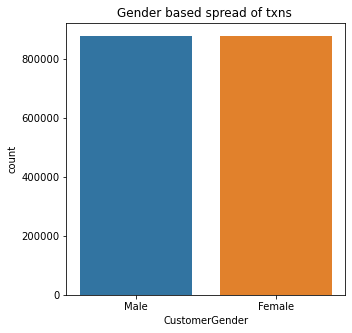

In [822]:
plt.figure(figsize=(5,5))
plt.title('Gender based spread of txns ')
sns.countplot (x=dfTxn['CustomerGender'])

In [869]:
df5 = dfTxn.groupby( ['Age', 'CustomerGender']).size().to_frame()

<AxesSubplot:xlabel='Age,CustomerGender'>

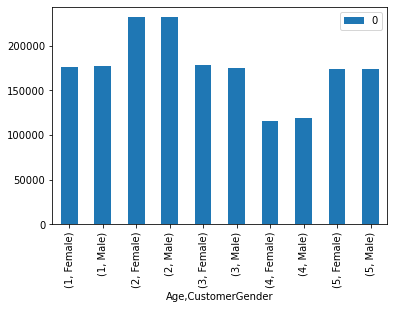

In [876]:
df5.plot(kind='bar')

 # based on AgeScore

<AxesSubplot:title={'center':'Age Category based spread of txns '}, xlabel='Age', ylabel='count'>

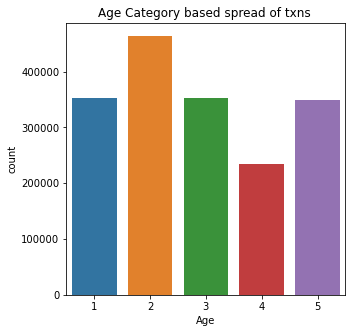

In [810]:
plt.figure(figsize=(5,5))
plt.title('Age Category based spread of txns ')
sns.countplot (x=dfTxn['Age'])

In [777]:
# dataframe which gives an idea of degree of relationship (orderScore) in between a customer and product
dfContent = dfValidation.groupby(['Product','CustomerId'])['Age'].size().reset_index()


In [778]:
dfContent.shape

(43905, 3)

In [779]:
dfTest.CustomerId.nunique()

100000

In [780]:
dfContent.columns

Index(['Product', 'CustomerId', 'Age'], dtype='object')

In [781]:
dfContent.CustomerId.unique().shape

(2843,)

In [782]:
dfContent.Product.unique().shape

(79,)

In [783]:
dfContent.head(2)

,Product,CustomerId,Age
0,agodavoucher,06RL1ZIQ2Y,1
1,agodavoucher,07HM2D5P3A,1


In [784]:
dfContentPivot = dfContent.pivot_table(index= 'Product', columns= 'CustomerId', values = 'Age').fillna(0)

In [785]:
dfContentPivot.index

Index(['agodavoucher', 'alexa', 'ballpen', 'bharatpetroleumvoucher', 'blouse',
       'bookmyshowgiftcard', 'books', 'brief', 'byjugiftcard', 'casualshoes',
       'cellphone', 'cleartripvoucher', 'cultfitvoucher', 'deodrant',
       'diamondjewellery', 'dreams11giftcard', 'exotictea', 'fancylights',
       'formalshoes', 'goldjewelley', 'googlehome', 'handbag', 'handkerchief',
       'headoutvoucher', 'headphone', 'homeautomation', 'hometheatre',
       'hotelmarriotgiftcard', 'hoteltajgiftcard', 'hotstarvoucher', 'inkpen',
       'irctcvoucher', 'jeans', 'kindle', 'laptop', 'laptopbag', 'lights',
       'luxurywatch', 'makemytripvoucher', 'menssuit', 'metalfurniture',
       'monitors', 'netflixvoucher', 'notepad', 'olacashcard', 'passportbag',
       'perfume', 'powerbank', 'printer', 'router', 'rummycirclegiftcard',
       'saree', 'shavingcream', 'shirt', 'skirt', 'sleepers', 'smartlights',
       'smartwatch', 'sonylivvoucher', 'speakers', 'sunglasses',
       'swiggycashcard', '

In [786]:
dfContentPivot.shape

(79, 2843)

In [787]:
mtrxContent = csr_matrix(dfContentPivot.values)

In [788]:
mtrxContent.shape

(79, 2843)

In [789]:
model = NearestNeighbors(n_neighbors=5, metric='cosine')

In [790]:
model.fit(mtrxContent)

NearestNeighbors(metric='cosine')

In [791]:
dfContentPivot[dfContentPivot.index == 'alexa']

CustomerId,02ABXKI4QM,02CX3T7MPG,02OMWQVGIT,039T4HVE87,03PE5QXRYK,04H9R1TO2A,04SYRO1CFL,05CO7ZDMLA,06HA8GM4CS,06RL1ZIQ2Y,...,ZT19NEWCMP,ZTGKFB7LJP,ZTL0XEAD19,ZUIX07NPT9,ZVCK5TADF3,ZW792VMIYA,ZW9U0R125N,ZX8K2WH1N3,ZYO1X7DGUE,ZYTUBVG5PQ
Product,,,,,,,,,,,,,,,,,,,,,
alexa,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [894]:
def kmeansContentRecos(PRODUCT='alexa', N_NEIGHBOURS=10):
    
    distances, indices = model.kneighbors( dfContentPivot[dfContentPivot.index == PRODUCT].values.reshape(1,-1),\
                                          n_neighbors=10)
    nearestProducts = []
    for i in range(0, len(distances.flatten())):
        if i == 0:
            print(f"Nearest Neighbours of Product : {dfContentPivot.index[indices.flatten()[i]]} ")
        else:
            product = dfContentPivot.index[indices.flatten()[i]]
            productDistance = distances.flatten()[i]
            print('{0}: Product={1}, with similarity of {2}%'.format(i, product, round((1-productDistance)*100, 4)))

            nearestProducts.append(product)



In [895]:
kmeansContentRecos()

Nearest Neighbours of Product : alexa 
1: Product=usbstick, with similarity of 26.9431%
2: Product=hotstarvoucher, with similarity of 23.9389%
3: Product=menssuit, with similarity of 23.874%
4: Product=tablet, with similarity of 23.7533%
5: Product=smartlights, with similarity of 23.6016%
6: Product=hometheatre, with similarity of 23.4458%
7: Product=hotelmarriotgiftcard, with similarity of 23.3042%
8: Product=metalfurniture, with similarity of 22.887%
9: Product=shavingcream, with similarity of 22.8034%


In [891]:
# lets select some random products

numProducts = len(dfProducts)

for _ in range(10):
    
    randomIdx = np.random.choice(numProducts)
    
    product = dfProducts.Product[randomIdx]
    print(f"\nIf customer is looking for {product=} , we recommend ... \n")
    kmeansContentRecos(PRODUCT=product)
    
    


If customer is looking for product='cleartripvoucher' , we recommend ... 

Nearest Neighbours of Product : cleartripvoucher 
1: Product=makemytripvoucher, with similarity of 25.9411%
2: Product=smartlights, with similarity of 23.9805%
3: Product=goldjewelley, with similarity of 23.8965%
4: Product=luxurywatch, with similarity of 23.6955%
5: Product=ballpen, with similarity of 23.5425%
6: Product=shirt, with similarity of 23.4528%
7: Product=usbcable, with similarity of 23.1768%
8: Product=saree, with similarity of 23.0118%
9: Product=powerbank, with similarity of 22.9982%

If customer is looking for product='cleartripvoucher' , we recommend ... 

Nearest Neighbours of Product : cleartripvoucher 
1: Product=makemytripvoucher, with similarity of 25.9411%
2: Product=smartlights, with similarity of 23.9805%
3: Product=goldjewelley, with similarity of 23.8965%
4: Product=luxurywatch, with similarity of 23.6955%
5: Product=ballpen, with similarity of 23.5425%
6: Product=shirt, with similari